# Modelling of physical systems

## Second Assignment

### Miłosz Góralczyk

## Numerical Integration of an Advection-Diffusion Problem

Advection-diffusion problem combines both elements of substance's mean moving with the force's direction, and the substance's spread in the medium.

We can view it as a combination of both prieviously modelled phenomena - advection and diffusion - into one, coherent physical model.

The equation for One-Dimensional Advection-Diffusion Equation can be written as:

$$
\frac{\partial C}{\partial t} + u \frac{\partial C}{\partial x} - D \frac{\partial^2 C}{\partial x^2} = 0
$$

$\frac{\partial c}{\partial t}$​ Time Derivative - Represents the rate of change of concentration over time.

$U \frac{\partial c}{\partial x}$ Advection Term - Describes the transport of concentration due to a uniform velocity *U*.

$D \frac{\partial^2 c}{\partial^2 x}$​ Diffusion Term - Models the spreading of the substance due to diffusion, governed by the diffusivity *D*.

The sum of time evolution, advection, and diffusion effects must balance. ($ = 0$)

### The Numerical Solution Equation

$$
C_i^{n+1} = C_i^n - \frac{u \Delta t}{\Delta x}(C_i^n - C_{i-1}^n) + \frac{D \Delta t}{(\Delta x)^2}(C_{i+1}^n - 2C_i^n + C_{i-1}^n)
$$

where:

- $C_i^n$ - Solute concentration at position i, time n - $kg/m^3$
- $u$ - Flow speed - $m/s$
- $D$ - Diffusion coefficient - $m^2/s$
- $\Delta x$ - Space step - $m$
- $\Delta t$ - time step - $s$
- $A$ - Cross-sectional area of the pipe/channel - $m^2$
- $M$ - Total mass of solute in a segment - $kg$

The explicit upwind scheme is defined as:
$$
  {\psi}^{{n}+1}_{i} = {\psi}^{n}_{i} - \left[F\left({\psi}^{n}_{i},  {\psi}^{n}_{{{blue}i}+1}, {C}\right)-F\left({\psi}^{n}_{{i}-1},{\psi}^{n}_{i}, {C}\right)\right]
$$
where
$$F(\psi_L, \psi_R, C)=\frac{C+|C|}{2}\psi_L + \frac{C-|C|}{2}\psi_R$$

## The Modelled problem

This scenario models the behavior of a concentrated, brightly colored pigment introduced into a glass pipe carrying flowing water. The objective is to track how the dye disperses and moves along the pipe over time.

By computing concentration values on a 2D grid—spanning discrete points in both space and time—we can approximate the temporal evolution of the dye's movement through the length of the pipe.

In this setup:
- 1kg of dye has been added to a pipe 
- pipe's radius is 0.5m
- advection coefficient, that is flowing water speed, is 0.75m/s
- Diffusion coefficient has set (arbitrally) as 0.005 
- the changes are tracked over the span of 30 seconds

This model helps visualize how the concentration changes as the dye is carried downstream and gradually spreads out due to diffusion.

In [22]:
from scipy import constants

r = 0.5 # radious of the source
M = 1.0 # mass of the source
A = round(r**r*constants.pi,2) # Area of cross section - 2.22
D = .005 # Diffusion coefficient
u = 0.75 # Advection coefficient - moving speed

x_max = 30 # tracked distance
t_max = 30 # tracked time


## Code Implementation

In [23]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim

In [24]:

def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

class shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub
    def __radd__(self, i): 
        return slice(i.start + self.add, i.stop + self.add)
    def __rsub__(self, i): 
        return slice(i.start - self.sub, i.stop - self.sub)

In [25]:
nx = 128

x, dx = np.linspace(0, x_max, nx+1, endpoint=True, retstep=True)
x = x[:-1] + dx/2

one = shift(add=1, sub=1)
hlf = shift(add=0, sub=1)

nt = 600
dt = t_max / nt

i = slice(1, nx-2)
im = slice(1, nx-1)

In [ ]:
# Analytic solution
# C_advection = u * dt / dx
C_advection = u * dt / dx

def C(x,t):
    ans = np.zeros(len(x))

    ans = (M/A) * (1/(2*np.sqrt(constants.pi * D))) * (x/ t ** (3/2)) * np.exp(-(((u*t)-x)**2)/(4*D*t))
    ans += 0.001
    return ans
print(A)
 

2.22


In [27]:
psi = C(x=x, t=1)
step_offset = int(nt / t_max)

C_diffusion = np.zeros(len(psi) - 1)
output = [psi.copy()]

# Loop over time steps
for _ in range(step_offset,nt):
    
    # Diffusion Step
    C_diffusion[im - hlf] = -2 * D * dt / dx**2 * (psi[im] - psi[im - one]) / (psi[im - one] + psi[im])

    assert max(abs(C_diffusion)) <= 1 
    psi[i] = psi[i] - (
        F(psi[i      ], psi[i + one], C_diffusion[i + hlf]) -
        F(psi[i - one], psi[i      ], C_diffusion[i - hlf]) 
    )

    # Advection Step
    psi[i] = psi[i] - (
        F(psi[i    ], psi[i+one], C_advection) -
        F(psi[i-one], psi[i    ], C_advection) 
    )

    # Boundary Conditions
    output += [psi.copy()]

In [28]:
def plot(step):
    fig = pyplot.figure()

    pyplot.plot(x, C(x=x, t=step*dt+1), label=f'analytic solution - step={step}')
    pyplot.plot(x, output[step], label=f'numeric solution - step={step}')

    pyplot.legend()
    pyplot.grid()
    pyplot.xlim(0, x_max)
    return fig 

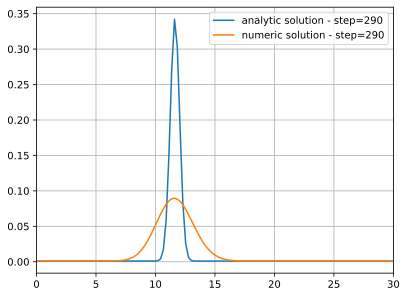


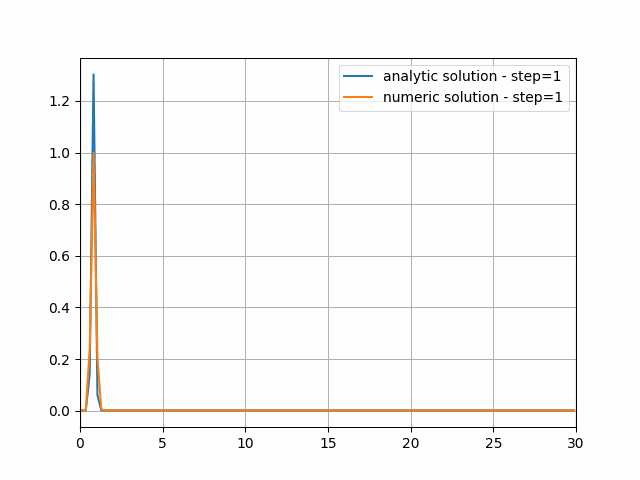

HTML(value="<a href='.\\full_comparison.gif' target='_blank'>.\\full_comparison.gif</a><br>")

In [30]:
plot((nt-step_offset) // 2)
show_plot('numeric.pdf')

show_anim(plot, range(1, nt-step_offset, 3), gif_file="full_comparison.gif")

# Results and conclusions

By applying the diffusion and advection equations, we have, within a degree of corectness, plotted the numerical outcome of the proposed problem, in addition to analytical one.

As we can see, both solutions follow the same path, with mean being near-identical in both numeric and analytic graphs.

Local truncation error - because we approximate the numerical derivatives with first order Taylor chain, our numerical result varies quite substantially when it comes to diffusion coefficient.

It displays quite clearly, that numerical solution are not ideal representation of the real solution.

On the next assignment we have learned how to deal with that issue applying a number of corrective iterations - calculating the error, then substracting it from the acquired solution.